<a href="https://colab.research.google.com/github/SteepDay/neural_networks/blob/main/vae_MXNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [44]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

Загрузка датасета

In [45]:
from __future__ import print_function
import os
import numpy as np
import cv2
import tensorflow.keras as keras
import random
from google.colab import drive
drive.mount('/content/drive/')

img_size = 64

save_dir = os.path.join(os.getcwd(), 'saved_models')
emb_model_name = 'celeba_emb_model.h5'

data_dir = 'datasets/'
ds_name = 'celeb15k'
ds_arc_file = 'celeb15k.zip'

def parse_cls_name_celeba(fn):
    return fn.split('.')[0]

def load_celeba_dataset(data_path, max_samples=15000):
    x_data = []
    print("Loading data from:", data_path)

    # Проверяем структуру папок
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Directory {data_path} does not exist")

    # Celeb15k может быть в подпапках или непосредственно в директории
    if os.path.exists(os.path.join(data_path, 'img_align_celeba')):
        data_path = os.path.join(data_path, 'img_align_celeba')

    fnames = [fn for fn in os.listdir(data_path) if fn.endswith(".jpg") or fn.endswith(".png")]
    print(f"Found {len(fnames)} images")
    random.shuffle(fnames)

    max_cnt = min(max_samples, len(fnames))
    for i, fn in enumerate(fnames[:max_cnt]):
        try:
            img = cv2.imread(os.path.join(data_path, fn))
            if img is None:
                continue
            img = cv2.resize(img, (img_size, img_size))
            x_data.append(img)
        except Exception as e:
            print(f"Error loading image {fn}: {str(e)}")

    x_data_np = np.asarray(x_data)
    print(f"Loaded {len(x_data)} images")
    return x_data_np

# Очищаем и создаем директории
!pwd
!rm -rf $data_dir
!mkdir -p $data_dir

# Скачиваем Celeb15k
!gdown --id 1B2D5RKkkV_b4ozeGr4F6Jp13AZldHUbC -O $ds_arc_file

# Распаковываем
!unzip -q $ds_arc_file -d $data_dir

# Проверяем содержимое распакованной папки
!ls -l $data_dir

# Загружаем данные
x_train = load_celeba_dataset(os.path.join(data_dir, ds_name), 15000)

# Нормализуем данные
x_train = x_train.astype('float32')
x_train /= 255

# Разделение на train/test
split_idx = int(len(x_train) * 0.95)
x_test = x_train[split_idx:]
y_test = x_train[split_idx:]
x_train = x_train[:split_idx]
y_train = x_train[:split_idx]

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1B2D5RKkkV_b4ozeGr4F6Jp13AZldHUbC
From (redirected): https://drive.google.com/uc?id=1B2D5RKkkV_b4ozeGr4F6Jp13AZldHUbC&confirm=t&uuid=644daedf-bb74-4f87-8766-0f2289a03faf
To: /content/celeb15k.zip
100% 105M/105M [00:00<00:00, 246MB/s] 
total 468
drwxr-xr-x 2 root root 475136 Feb 27  2024 celeb15k
Loading data from: datasets/celeb15k
Found 15000 images
Loaded 15000 images
x_train shape: (14250, 64, 64, 3)
x_test shape: (750, 64, 64, 3)
14250 train samples
y_train shape: (14250, 64, 64, 3)


Create a sampling layer

In [46]:
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

Build the encoder

In [47]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(img_size, img_size, 3))
x = layers.Conv2D(64, 3, strides=2, padding="same")(encoder_inputs)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_55      │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ leaky_re_lu_55[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_56      │ (None, 16, 16,    │          0 │ conv2d_25[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ leaky_re_lu_56[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_57      │ (None, 8, 8, 256) │          0 │ conv2d_26[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ leaky_re_lu_57[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 4, 4, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_58      │ (None, 4, 4, 512) │          0 │ conv2d_27[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ leaky_re_lu_58[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 8192)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │  2,097,408 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_59      │ (None, 256)       │          0 │ dense_11[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     16,448 │ leaky_re_lu_59[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     16,448 │ leaky_re_lu_59[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_6          │ (None, 64)        │          0 │ z_mean[0][0],   

 Total params: 3,685,120 (14.06 MB)

 Trainable params: 3,683,200 (14.05 MB)

 Non-trainable params: 1,920 (7.50 KB)

Build the decoder

In [48]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 512)(latent_inputs)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Reshape((4, 4, 512))(x)
x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8192)           │       532,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_60 (LeakyReLU)      │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_61 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_62 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_63 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_64 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,135,235 (8.15 MB)

 Trainable params: 2,117,891 (8.08 MB)

 Non-trainable params: 17,344 (67.75 KB)

Define the VAE as a Model with a custom train_step

In [57]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction), axis=[1, 2, 3]
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss * 0.1
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

Обучение VAE

In [60]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
vae.fit(x_train, epochs=50, batch_size=128)  # Увеличил до 50 эпох

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - kl_loss: 149.2406 - loss: 196.4078 - reconstruction_loss: 181.4837
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - kl_loss: 149.6436 - loss: 188.6602 - reconstruction_loss: 173.6958
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - kl_loss: 150.0174 - loss: 181.7051 - reconstruction_loss: 166.7034
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - kl_loss: 150.6909 - loss: 177.5584 - reconstruction_loss: 162.4893
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - kl_loss: 151.6674 - loss: 173.8483 - reconstruction_loss: 158.6815
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - kl_loss: 152.4867 - loss: 169.2709 - reconstruction_loss: 154.0222
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - kl_loss: 153.3134 - loss: 167.5008 - reconstruction_loss: 152.1694
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - kl_loss: 154.0275 - loss: 162.8417 - reconstruction_loss: 147.4389
Epoch 9/50
112/112 

Тест восстановления

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


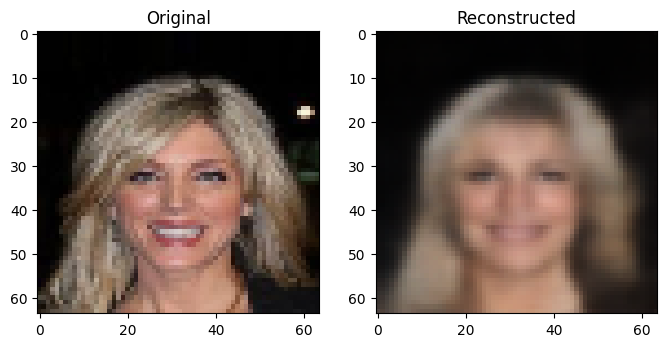

In [61]:
import matplotlib.pyplot as plt

i = 15 # номер тестовой фотографии

images = []
images.append(np.expand_dims(x_train[i], axis=0))
np_images = np.vstack(images)

emb = vae.encoder.predict(np_images)[2]
x_decoded = vae.decoder.predict(emb)
digit = x_decoded[0].reshape(img_size, img_size, 3)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(cv2.cvtColor(digit, cv2.COLOR_BGR2RGB))
plt.show()

Генерация лиц

x_train shape: (14250, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━

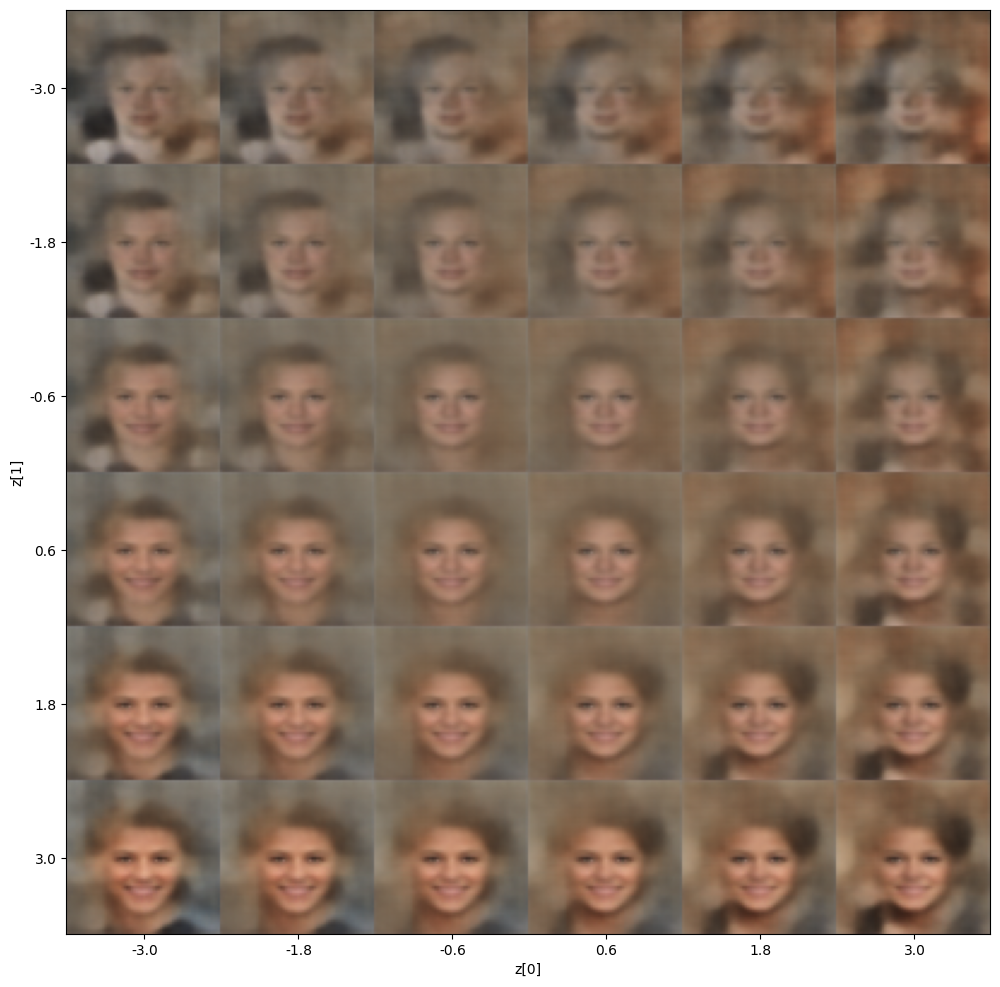

In [62]:
import matplotlib.pyplot as plt

#какие компоненты вектора эмбеддинга будем менять циклически (остальные останутся нулями)
e1 = 2
e2 = 3

def plot_latent_space(vae, n=6, figsize=12):
    # display a n*n 2D manifold of digits

    scale = 3.0
    figure = np.zeros((img_size * n, img_size * n, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)#[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.zeros((1,latent_dim))
            #z_sample[0,:] = 1
            z_sample[0,e1] = xi
            z_sample[0,e2] = yi
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_size, img_size, 3)
            digit = cv2.cvtColor(digit, cv2.COLOR_BGR2RGB)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

print('x_train shape:', x_train.shape)
plot_latent_space(vae)

Векторная арифметика

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


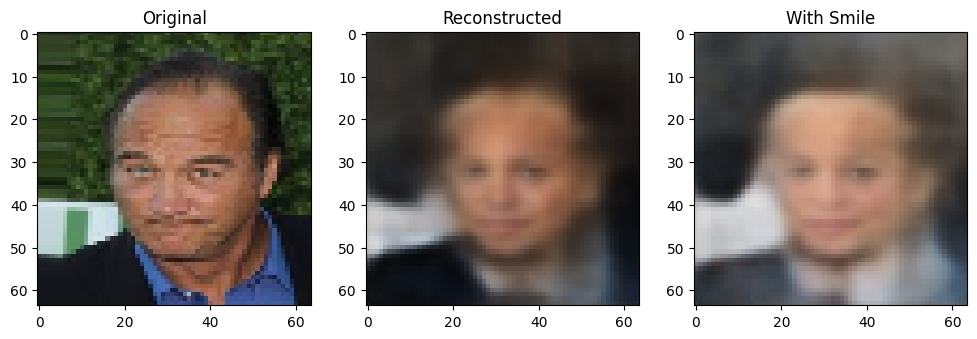

In [64]:
def find_images_with_expression(base_dir, expression, n=5):
    all_files = [f for f in os.listdir(base_dir) if f.endswith('.png') or f.endswith('.jpg')]
    selected = []
    for f in all_files:
        if len(selected) >= n:
            break
        img = cv2.imread(os.path.join(base_dir, f))
        img = cv2.resize(img, (img_size, img_size))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # mouth_roi для 64x64 лучше взять чуть выше
        mouth_roi = gray[40:60, 16:48]
        if expression == 'smile':
            if np.mean(mouth_roi) > 100:
                selected.append(img)
        else:
            if np.mean(mouth_roi) < 80:
                selected.append(img)
    return selected[:n]

# Находим примеры улыбающихся и не улыбающихся лиц
smiling_faces = find_images_with_expression(os.path.join(data_dir, ds_name), 'smile', 10)
neutral_faces = find_images_with_expression(os.path.join(data_dir, ds_name), 'neutral', 10)

def prepare_images(imgs):
    if len(imgs) == 0:
        raise ValueError("Список изображений пуст!")
    imgs = [cv2.resize(img, (img_size, img_size)) for img in imgs]
    np_imgs = np.array(imgs).astype('float32') / 255.0
    return np_imgs

smiling_imgs = prepare_images(smiling_faces)
neutral_imgs = prepare_images(neutral_faces)

# Получаем эмбеддинги
smiling_embs = vae.encoder.predict(smiling_imgs)[2]
neutral_embs = vae.encoder.predict(neutral_imgs)[2]

# Вычисляем средний вектор улыбки
avg_smiling = np.mean(smiling_embs, axis=0)
avg_neutral = np.mean(neutral_embs, axis=0)
smile_vector = avg_smiling - avg_neutral

# Выбираем тестовое изображение
test_img = x_test[10:11]  # Берем одно изображение из тестового набора
test_emb = vae.encoder.predict(test_img)[2]

# Добавляем улыбку
smiled_emb = test_emb + smile_vector * 0.7  # Коэффициент для регулирования силы улыбки

# Декодируем результаты
original_recon = vae.decoder.predict(test_emb)[0]
smiled_recon = vae.decoder.predict(smiled_emb)[0]

# Визуализация
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(test_img[0], cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.title("Reconstructed")
plt.imshow(cv2.cvtColor(original_recon, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.title("With Smile")
plt.imshow(cv2.cvtColor(smiled_recon, cv2.COLOR_BGR2RGB))
plt.show()